In [4]:
import sys
sys.path.append('../../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from rcgp.rcgp import TemporalRCGP
from rcgp.kernels import Matern32Kernel

plt.rc('font', family='serif', size=14)

In [5]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility
    x = tc.linspace(0, 1, 100) 
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix, mean = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x)), tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)
    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [50, 51, 53, 54, 57, 59, 65]
    outliers_loc = [50, 51, 53, 54, 55, 56, 57, 59, 65]

    noise = tc.distributions.Normal(loc=0, scale=20.).sample((len(outliers_loc), ))
    y_outliers[outliers_loc] = y_outliers[outliers_loc] + noise
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.2, 2., 0.25)
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

# Optimization

NOTE: Results of coverage plot and efficiency are sensitive to optimization procedure (i.e., stopping earlier or later will yield over or under confident plots). For the general practictioners, this makes no difference because the fit is roughly the same (the key word here is roughly).

In [6]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor, weighted_loss : bool):
    S = covs + R
    eps = (Ys - preds).unsqueeze(-1)

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    if weighted_loss:
        Ws = (Ws / Ws.sum()).squeeze()
        return tc.dot(Ws, energies)
    else:
        return tc.sum(energies)
    

def coverage(preds, std, Ys):
    quantiles = np.append(np.arange(0.05, 1, 0.05), 0.9973)
    coverage_vals = []
    for confidence_level in quantiles:
        z_val = norm.ppf(1 - (1 - confidence_level)/2)
        lb = preds - z_val * std
        ub = preds + z_val * std

        is_within_bounds = (Ys >= lb) & (Ys <= ub)
        coverage_vals.append(is_within_bounds.mean())
    
    return quantiles, coverage_vals


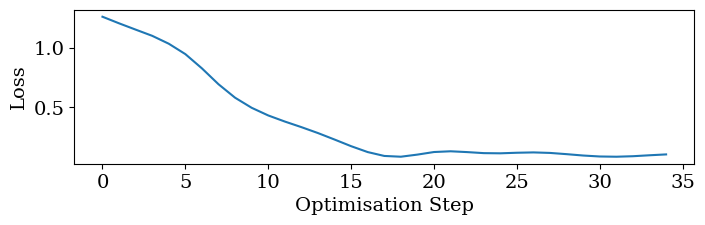

In [17]:
lr = 0.3 #Learning Rate
n_steps=35 #Number of Optimisation Steps
verbose=False #To print loss/params at each # steps
losses = [] #For plotting losses
adaptive_c, c_factor = True, 1. #If c is adaptive. If this is True c = ... below is overwritten/not used
robust, robust_func = True, "m_pred" #If robust, it's the ST-RCGP with specified robust function. If not, STGP, and c/beta are not used, and weights=1
outliers = True #If we want to fit outliers
weighted_loss=  True #If we want a weighted loss
c = 5. #If we set adaptive_c = False, this value becomes relevant. If c=None, defaults to 2 * sqrt(var_y)

if outliers:
    strcgp = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys_outliers.reshape(-1,1), p=1)
else:
    strcgp = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys.reshape(-1,1), p=1)

strcgp.c = c
if adaptive_c: strcgp.adaptive_c(c_factor=c_factor)
if robust: strcgp.activate_robustness(func=robust_func)

optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

for step in range(n_steps):
    _,(preds, covs, R, Ws), _ = strcgp.forward()
    loss = scoring_rule(Ys=Ys.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws, weighted_loss=weighted_loss)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

    if verbose and step%5==0:
        print(f"---------step {step}----------")
        print("Loss : {}".format(loss.detach().clone()))

        for name, param in strcgp.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")
        print("-------------------------\n")

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [18]:
print("lengthscale : ", strcgp.temporal_lengthscale.item())
print("magnitude : ", strcgp.temporal_magnitude.item())
print("variance y : ", strcgp.var_y.item())

lengthscale :  0.2290690392255783
magnitude :  3.414802074432373
variance y :  0.026679275557398796


Efficiency in Well-Specified :  tensor(0.7523)
Efficiency Total :  tensor(0.6966)


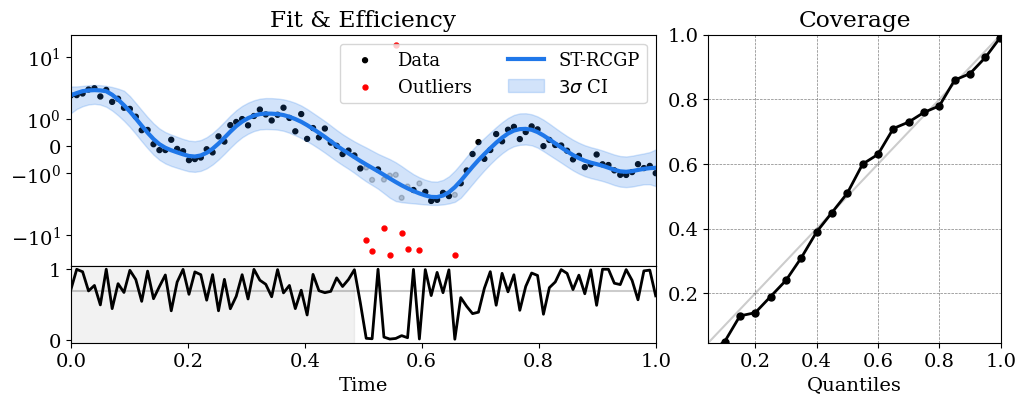

In [ ]:
with tc.no_grad(): 
    (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
    pred_strcgp = pred_strcgp.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()
    
quantiles, coverage_vals = coverage(pred_strcgp, std_strcgp, Ys.numpy())

# Create a mosaic layout
fig, axs = plt.subplot_mosaic(
    [
        ["top_left", "quantile"],
        ["bottom_left", "quantile"]
    ],
    figsize=(12, 4),
    #sharex=False,
    gridspec_kw={"width_ratios": [2, 1], "height_ratios": [3, 1]}
)

# Top Left Plot
if outliers:
    colors = ['black' if i not in outliers_loc else (0,0,0,0.2) for i in range(len(Xs))]
    axs['top_left'].scatter(Xs, Ys, c=colors, s=50, marker='.', label="Data")
    axs['top_left'].scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=50, marker='.', label="Outliers")
else:
    axs['top_left'].scatter(Xs, Ys, s=50, c='black', marker='.', label="Data")


axs['top_left'].plot(Xs, pred_strcgp, linewidth=3, linestyle='-', color="#1f77e9", label="ST-RCGP")
axs['top_left'].fill_between(Xs, pred_strcgp - 3 * std_strcgp, pred_strcgp + 3 * std_strcgp, color="#1f77e9", alpha=0.2, label=r"$3\sigma$ CI")
if outliers: axs['top_left'].set_yscale('symlog')
axs['top_left'].set_xlim(Xs[0], Xs[-1])
axs['top_left'].legend(ncol=2, fontsize=13, loc="upper right")
axs['top_left'].set_title("Fit & Efficiency")
axs['top_left'].set_xticks([])
#axs['top_left'].set_ylabel("Observations")

# Top Right Plot
axs["quantile"].set_title("Coverage")
axs["quantile"].plot(quantiles, coverage_vals, "k.-", linewidth=2, markersize=10)
axs["quantile"].plot(quantiles, quantiles, "k-", alpha=0.2)
axs["quantile"].set_xlabel("Quantiles")
#axs["quantile"].set_ylabel("Coverage")
nudge = 0.003
axs["quantile"].set_xlim(quantiles[0] - nudge, quantiles[-1] + nudge)
axs["quantile"].set_ylim(quantiles[0] - nudge, quantiles[-1] + nudge)
axs["quantile"].grid(color = 'gray', linestyle = '--', linewidth = 0.5)


# Bottom Left Plot
axs["bottom_left"].plot(Xs, strcgp_eff, color="black", linewidth=2)
mean_eff_total = strcgp_eff.mean()
axs["bottom_left"].hlines(mean_eff_total, xmin=Xs[0], xmax=Xs[-1], color='black', alpha=0.2)
axs["bottom_left"].set_xlim(Xs[0], Xs[-1])
ymin, ymax = axs["bottom_left"].get_ylim()
well_specified_idx =49
if outliers:
    axs["bottom_left"].fill_between(Xs[:well_specified_idx], ymin, ymax, color='black', alpha=0.05)
    print("Efficiency in Well-Specified : ", strcgp_eff[:well_specified_idx].mean())
print("Efficiency Total : ", mean_eff_total)
#axs["bottom_left"].set_title(f"Efficiency : {mean_eff:.2f}")
#axs["bottom_left"].set_ylabel("Efficiency")
axs["bottom_left"].set_xlabel("Time")
axs["bottom_left"].set_ylim(ymin, ymax)

# Adjust layout
fig.subplots_adjust(wspace=0.12, hspace=0.0)  # Reduce spacing between subplots
#fig.tight_layout()
#fig.savefig("../results/efficiency-and-coverage-and-fit-plot.pdf", format='pdf', bbox_inches='tight')

Observations:

Because the adaptive c yields an inference engine with heteroskedasticity, it is a natural choice to have an energy function that has the same feature, i.e. weighted.


with outliers:
1) Higher c factor -> less efficiency

without outliers:
1) non-weighted loss yields under-confident estimates. Weighted loss yields ideal estimates. Explanation: Down-weight larger (y-pred), so that larger variance doesn't reduce loss.
2) weighted loss stabilizes the optimization process. 
3) weighted loss always yields estimate with slightly less efficiency. But difference is marginal (0.05 at most).